In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# install library untuk split datasetnya menjadi validation set dan training set
# pip install split-folders

In [ ]:
# import splitfolders

In [3]:
# mount gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Split into training and validation set

# src_dir = '/content/drive/My Drive/Capstone'
# output_dir = '/content/drive/My Drive/Capstone1'

# splitfolders.ratio(src_dir, output=output_dir, seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 12059 files [05:29, 36.56 files/s] 


In [4]:
# Define the training and validation base directories
train_dir = '/content/drive/My Drive/Capstone1/train'
validation_dir = '/content/drive/My Drive/Capstone1/val'

# Directory with training normal chest x-ray
train_normal_dir = os.path.join(train_dir, 'normal')
# Directory with training covid pneumonia chest x-ray
train_covid_dir = os.path.join(train_dir,'covid')
# Directory with training bacterial pneumonia chest x-ray
train_bacterial_dir = os.path.join(train_dir,'bacterial')
# Directory with training viral pneumonia chest x-ray
train_viral_dir = os.path.join(train_dir,'viral')

# Directory with validation normal chest x-ray
val_normal_dir = os.path.join(validation_dir, 'normal')
# Directory with validation covid pneumonia chest x-ray
val_covid_dir = os.path.join(validation_dir, 'covid')
# Directory with validation bacterial pneumonia chest x-ray
val_bacterial_dir = os.path.join(validation_dir, 'bacterial')
# Directory with validation viral pneumonia chest x-ray
val_viral_dir = os.path.join(validation_dir, 'viral')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_normal_dir))} images of normal lungs for training.\n")
print(f"There are {len(os.listdir(train_covid_dir))} images of covid pneumonia for training.\n")
print(f"There are {len(os.listdir(train_bacterial_dir))} images of bacterial pneumonia for training.\n")
print(f"There are {len(os.listdir(train_viral_dir))} images of viral pneumonia for training.\n")

print(f"There are {len(os.listdir(val_normal_dir))} images of normal lungs for validation.\n")
print(f"There are {len(os.listdir(val_covid_dir))} images of covid pneumonia for validation.\n")
print(f"There are {len(os.listdir(val_bacterial_dir))} images of bacterial pneumonia for validation.\n")
print(f"There are {len(os.listdir(val_viral_dir))} images of viral pneumonia for validation.\n")

There are 2423 images of normal lungs for training.

There are 2400 images of covid pneumonia for training.

There are 2412 images of bacterial pneumonia for training.

There are 2411 images of viral pneumonia for training.

There are 606 images of normal lungs for validation.

There are 600 images of covid pneumonia for validation.

There are 604 images of bacterial pneumonia for validation.

There are 603 images of viral pneumonia for validation.



Sample of normal lungs image:


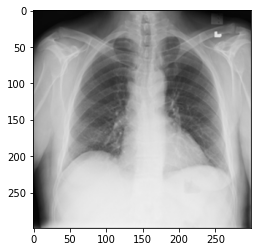


Sample of covid pneumonia image:


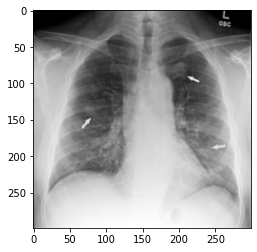

In [5]:
print("Sample of normal lungs image:")
plt.imshow(load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])}"))
plt.show()

print("\nSample of covid pneumonia image:")
plt.imshow(load_img(f"{os.path.join(train_covid_dir, os.listdir(train_covid_dir)[0])}"))
plt.show()

In [6]:
# Load the first example of a normal lungs
sample_image  = load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (299, 299, 3)


In [14]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='categorical',
                                                      target_size=(299, 299))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='categorical',
                                                                target_size=(299, 299))
  ### END CODE HERE
  return train_generator, validation_generator

In [15]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 9646 images belonging to 4 classes.
Found 2413 images belonging to 4 classes.


In [16]:
from tensorflow.keras.applications.xception import Xception

In [27]:
xception = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))
output = xception.layers[-1].output
output = tf.keras.layers.Flatten()(output)
xceptionmodel=Model(xception.input,output)
for layers in (xceptionmodel.layers):
    print(layers)
    layers.trainable = True
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(xceptionmodel)
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [23]:
# pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
#                                 include_top = False, 
#                                 weights = None)
# # Make all the layers in the pre-trained model non-trainable
# for layer in pre_trained_model.layers:
#   layer.trainable = False

# # Print out the pretrained model summary
# pre_trained_model.summary()

NameError: ignored

In [30]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
# Define the desired layer of pretrained model
# desired_layer = pre_trained_model.get_layer('mixed7')
# print('last layer output shape: ', desired_layer.output_shape)
# last_output = desired_layer.output
# print('last layer output: ', last_output)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import SGD

In [ ]:
# def create_final_model(pre_trained_model, last_output):
#   # Flatten the output layer to 1 dimension
#   x = layers.Flatten()(last_output)

#   ### START CODE HERE

#   # Add a fully connected layer with 1024 hidden units and ReLU activation
#   x = layers.Dense(1024, activation='relu')(x)
#   # Add a dropout rate of 0.2
#   x = layers.Dropout(0.2)(x)
#   # Add a final sigmoid layer for classification
#   x = layers.Dense(1, activation='sigmoid')(x)        

#   # Create the complete model by using the Model class
#   model = Model(inputs=pre_trained_model.input, outputs=x)

#   # Compile the model
#   model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
#                 loss = 'categorical_crossentropy',
#                 metrics = ['accuracy'])

#   ### END CODE HERE
  
#   return model

In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator, 
                    epochs = 20,
                    callbacks=callbacks)

Epoch 1/20
302/302 [==============================] - 396s 1s/step - loss: 1.1098 - accuracy: 0.5352 - val_loss: 3.1123 - val_accuracy: 0.4878
Epoch 2/20
302/302 [==============================] - 396s 1s/step - loss: 0.6114 - accuracy: 0.7788 - val_loss: 0.6469 - val_accuracy: 0.7480
Epoch 3/20
302/302 [==============================] - 396s 1s/step - loss: 0.4404 - accuracy: 0.8314 - val_loss: 0.6567 - val_accuracy: 0.7037
Epoch 4/20
302/302 [==============================] - 395s 1s/step - loss: 0.5160 - accuracy: 0.8265 - val_loss: 0.5043 - val_accuracy: 0.7522
Epoch 5/20
302/302 [==============================] - 395s 1s/step - loss: 0.4292 - accuracy: 0.8511 - val_loss: 0.9568 - val_accuracy: 0.7281
Epoch 6/20
302/302 [==============================] - 397s 1s/step - loss: 0.8168 - accuracy: 0.7855 - val_loss: 1.6656 - val_accuracy: 0.6138
Epoch 7/20
302/302 [==============================] - 395s 1s/step - loss: 0.5317 - accuracy: 0.8279 - val_loss: 1.5705 - val_accuracy: 0.6643

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()